# figure demonstrating the principles of event-based cameras

inspiration from https://lenzgregor.com/posts/event-cameras/



In [1]:
bias = .3
N_threshold = 25
N_frame = 30
smoothing = 10.0
smoothing = 15.0

In [2]:
import os
import numpy as np
phi = np.sqrt(5)/2 + 1/2

import matplotlib
import matplotlib.pyplot as plt

import matplotlib
subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)

figpath = None
figpath = '.'

dpi = 300
ext = 'svg'

def printfig(fig, name, ext=ext, figpath=figpath, dpi=None, bbox='tight'):
    fig.savefig(os.path.join(figpath, name + '.' + ext), dpi = dpi, bbox_inches=bbox, transparent=True)

if not(figpath is None): os.makedirs(figpath, exist_ok=True)

# define signal

Get a raw signal, time-filter it

In [3]:
fname = '/Users/laurentperrinet/Documents/GitHub/MotionClouds/docs/files/montypython.npy'
fname = '/Users/laurentperrinet/quantic/science/Hugo/OrientationPrecision/deep-bandwidth_old/datasets/montypython.npy'
movie = np.exp(np.load(fname))
movie.shape

(54, 54, 4096)

In [4]:
i_x, i_y = 0, 0
i_t_start, i_t_end = 0, 5000
i_t_start, i_t_end = 1500, 2500
i_t_middle = (i_t_end - i_t_start) //2


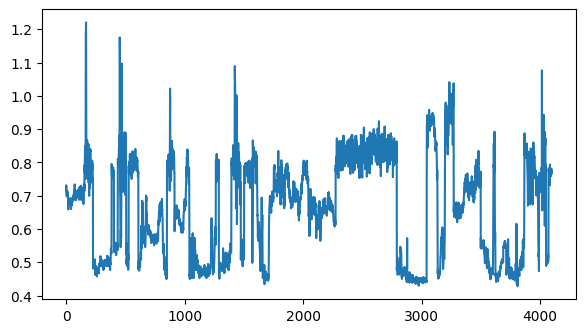

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(phi*4, 4), subplotpars=subplotpars)
ax.plot(movie[i_x, i_y, :] - bias)


In [6]:
movie_line = movie[i_x, i_y, i_t_start:i_t_end] - bias

(1000,)

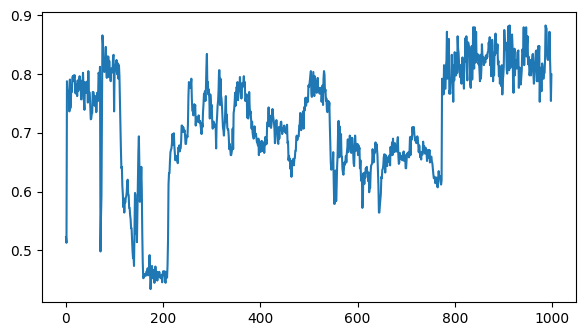

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(phi*4, 4), subplotpars=subplotpars)
ax.plot(movie_line)
movie_line.shape

In [8]:
# from scipy.signal import spline_filter
from scipy.signal import cspline1d, cspline1d_eval
time = np.linspace(0, i_t_end - i_t_start, 500)
movie_line = cspline1d_eval(cspline1d(movie_line, smoothing), time)
movie_line.shape, time.shape

((500,), (500,))

In [9]:
movie_line = cspline1d_eval(cspline1d(movie[i_x, i_y, :] - bias, smoothing), np.linspace(0, i_t_end - i_t_start, 500))
movie_line.shape, time.shape

((500,), (500,))

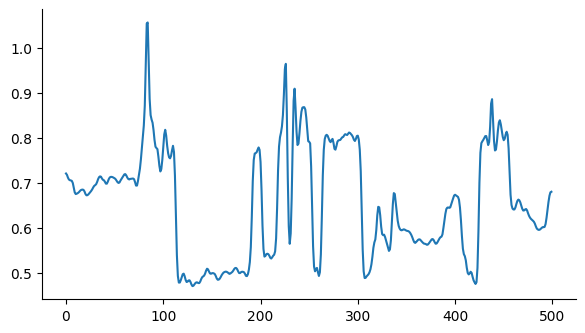

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(phi*4, 4), subplotpars=subplotpars)
ax.plot(movie_line)

# ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')

In [11]:
ymax = np.max(movie_line)
np.linspace(0, ymax, N_threshold, endpoint=True).shape, N_threshold

((25,), 25)

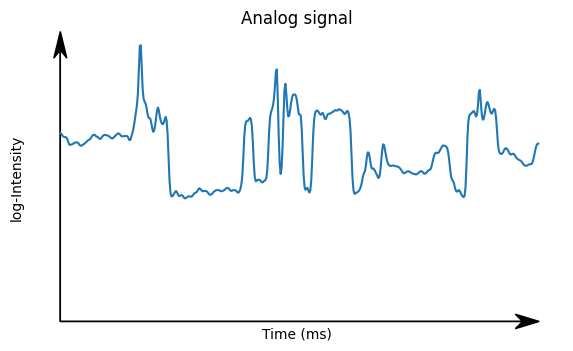

In [12]:
def do_plot(movie_line, N_frame=0, N_threshold=0,
            show_events=True,
            N_event=-1,
            ylabel='log-Intensity',
            xlabel='Time (ms)',
            title='Analog signal',
):
    tmax = len(movie_line)
    ymax = np.max(movie_line)*1.05

    fig, ax = plt.subplots(1, 1, figsize=(phi*4, 4), subplotpars=subplotpars)

    # compute events
    if N_threshold>0:

        events = []
        
        ysamples = np.linspace(0, ymax, N_threshold, endpoint=True)
        threshold = ymax / (N_threshold-1)
        i_movie_quant = int(movie_line[0] * N_threshold / ymax)
        movie_quant = ysamples[i_movie_quant]

        for i_time in range(tmax):
            while np.abs(movie_line[i_time]-movie_quant)>threshold: # TODO : /2:
                # print(i_time, np.abs(amp-movie_quant)/threshold)
                pol = np.sign(movie_line[i_time]-movie_quant)
                movie_quant += pol * threshold
                events.append((i_time, pol, movie_quant))
                
        if N_event == -1: 
            N_event = len(events)
            i_time_last = len(movie_line)
        else:
            # if N_event==1:
            #     i_time_previous = 0
            # else:
            #     i_time_previous = events[N_event-1][0]
            i_time_last = events[N_event-1][0]
    else:
        i_time_last = len(movie_line)
                   
    # show the signal
    ax.plot(movie_line[:i_time_last])
    ax.set_ylim(0, ymax)
    # show the segment that crossed the threshold
    if N_threshold>0 and N_event < len(events):
        ax.plot([i_time_last-1, i_time_last], 
                [movie_line[i_time_last-1], movie_line[i_time_last]], 
                'b-', ms=4)
        # ax.plot([i_time_previous, i_time_last], 
        #         [movie_line[i_time_previous], movie_line[i_time_last]], 'b-', ms=4)
    # ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    # ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_color('none')

    # https://3diagramsperpage.wordpress.com/2014/05/25/arrowheads-for-axis-in-matplotlib/
    # removing the default axis on all sides:
    for side in ['bottom','right','top','left']:
        ax.spines[side].set_visible(False)
    
    # removing the axis ticks
    plt.xticks([]) # labels 
    plt.yticks([])
    ax.xaxis.set_ticks_position('none') # tick markers
    ax.yaxis.set_ticks_position('none')

    # matching arrowhead length and width

    # xmin, tmax = ax.get_xlim() 
    # ymin, ymax = ax.get_ylim()
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height
    
    # manual arrowhead width and length
    hw = 1./20.*ymax
    hl = 1./20.*tmax
    lw = 1. # axis line width
    ohg = 0.3 # arrow overhang
    
    # compute matching arrowhead length and width
    # yhw = hw/(ymax-ymin)*(tmax-xmin)* height/width 
    # yhl = hl/(tmax-xmin)*(ymax-ymin)* width/height
    yhw = hw/ymax*tmax * height/width 
    yhl = hl/tmax*ymax * width/height
    
    # draw x and y axis
    ax.arrow(0, 0, tmax, 0., fc='k', ec='k', lw = lw, 
            head_width=hw, head_length=hl, overhang = ohg, 
            length_includes_head= True, clip_on = False) 
    
    ax.arrow(0, 0, 0., ymax, fc='k', ec='k', lw = lw, 
            head_width=yhw, head_length=yhl, overhang = ohg, 
            length_includes_head= True, clip_on = False) 
    ax.set_ylabel(ylabel)

    ax.set_xlabel(xlabel)
    ax.set_title(title)

    if N_frame>0:
        
        samples = np.linspace(0, int(tmax*.95), N_frame, dtype=int)
        for i_sample, sample in enumerate(samples):
            ax.plot([sample, sample], [0, ymax], 'k', ls='dotted', lw=.2)
            ax.plot([sample], [movie_line[sample]], 'o', color='orangered', fillstyle='none', lw=1)

 
    if N_threshold>0:
        
        for ysample in ysamples[1:]:
            ax.plot([0, tmax], [ysample-threshold/2, ysample-threshold/2], 'k--', lw=.2)
        
        for ysample in ysamples:
            ax.plot([0, tmax], [ysample, ysample], 'k', lw=.2)

        print(events[:(N_event)])
        for i_time, pol, movie_quant in events[:(N_event)]:
            ax.plot([i_time], [movie_quant], 
                     'r^' if pol == +1 else 'bv', alpha=.4)
            if show_events: ax.plot([i_time, i_time], [0, ymax/N_threshold], 'r' if pol == +1 else 'b', lw=.5)

    return fig, ax

fig, ax = do_plot(movie_line)


In [13]:
printfig(fig, 'analog_signal')

# do frames

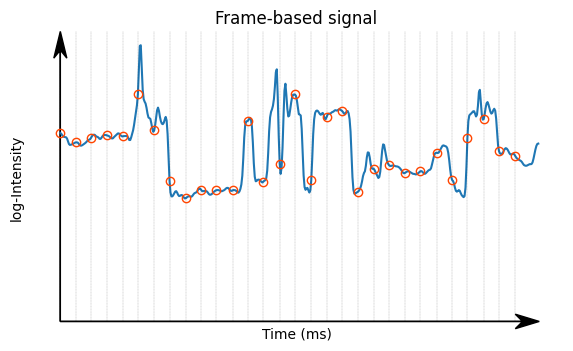

In [14]:
fig, ax = do_plot(movie_line, N_frame=N_frame, title='Frame-based signal')
printfig(fig, 'frame-based_signal')

# do events

In [15]:
# for N_event in [1, 5, 10, 50]:
#     fig, ax = do_plot(movie_line[:1000]-.425, N_threshold=N_threshold, N_event=N_event, show_events=False, title='Event-based signal')
#     plt.show()
#     printfig(fig, f'event-based_signal_raw_{N_event}')

In [16]:

movie_line_short = movie_line[:200]-.370
movie_line.shape, movie_line_short.shape

((500,), (200,))

[(21, -1.0, 0.3033568401287304)]


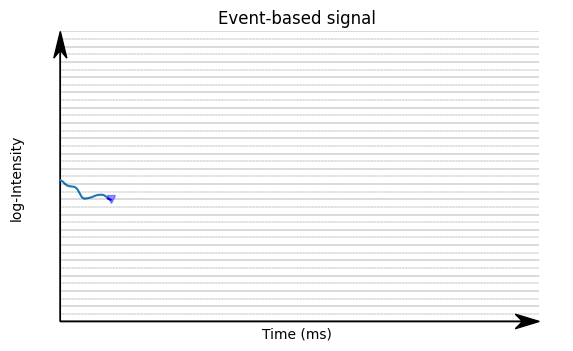

[(21, -1.0, 0.3033568401287304), (34, 1.0, 0.3412764451448217)]


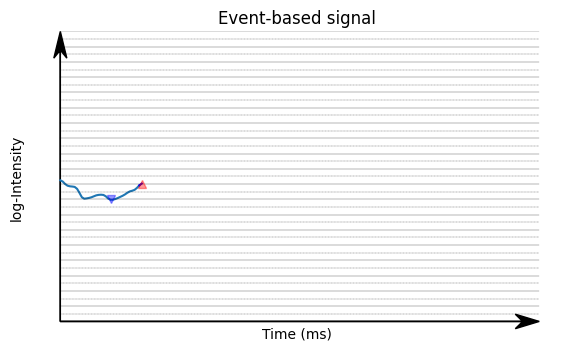

[(21, -1.0, 0.3033568401287304), (34, 1.0, 0.3412764451448217), (77, 1.0, 0.379196050160913), (79, 1.0, 0.41711565517700433), (80, 1.0, 0.45503526019309565)]


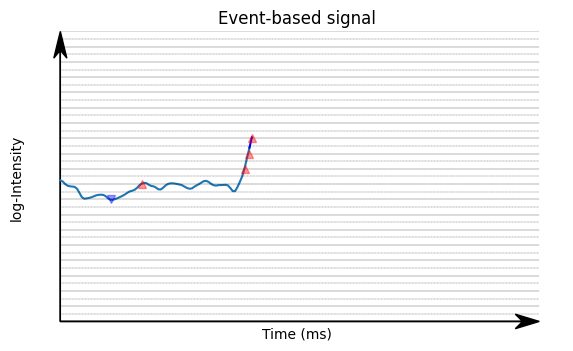

[(21, -1.0, 0.3033568401287304), (34, 1.0, 0.3412764451448217), (77, 1.0, 0.379196050160913), (79, 1.0, 0.41711565517700433), (80, 1.0, 0.45503526019309565), (81, 1.0, 0.49295486520918697), (82, 1.0, 0.5308744702252782), (82, 1.0, 0.5687940752413695), (83, 1.0, 0.6067136802574608), (83, 1.0, 0.644633285273552)]


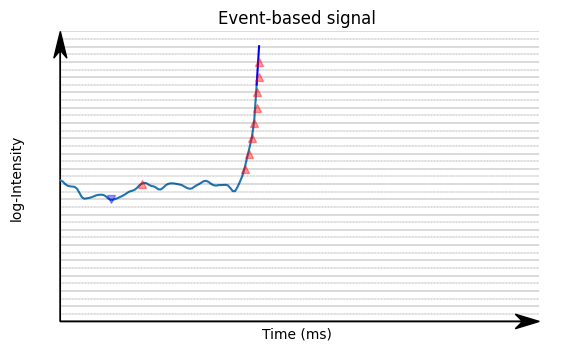

[(21, -1.0, 0.3033568401287304), (34, 1.0, 0.3412764451448217), (77, 1.0, 0.379196050160913), (79, 1.0, 0.41711565517700433), (80, 1.0, 0.45503526019309565), (81, 1.0, 0.49295486520918697), (82, 1.0, 0.5308744702252782), (82, 1.0, 0.5687940752413695), (83, 1.0, 0.6067136802574608), (83, 1.0, 0.644633285273552), (83, 1.0, 0.6825528902896433), (85, -1.0, 0.644633285273552), (85, -1.0, 0.6067136802574608), (86, -1.0, 0.5687940752413695), (86, -1.0, 0.5308744702252782), (87, -1.0, 0.4929548652091869), (90, -1.0, 0.4550352601930956), (92, -1.0, 0.4171156551770043), (96, -1.0, 0.37919605016091296), (101, 1.0, 0.4171156551770043)]


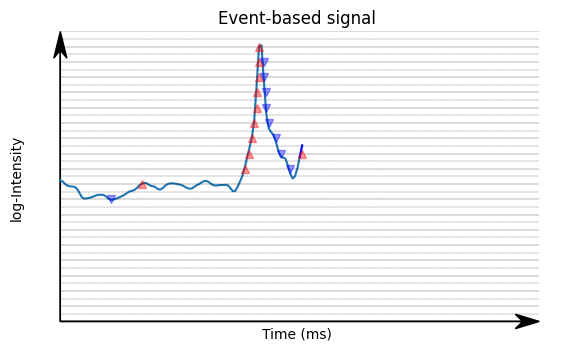

[(21, -1.0, 0.3033568401287304), (34, 1.0, 0.3412764451448217), (77, 1.0, 0.379196050160913), (79, 1.0, 0.41711565517700433), (80, 1.0, 0.45503526019309565), (81, 1.0, 0.49295486520918697), (82, 1.0, 0.5308744702252782), (82, 1.0, 0.5687940752413695), (83, 1.0, 0.6067136802574608), (83, 1.0, 0.644633285273552), (83, 1.0, 0.6825528902896433), (85, -1.0, 0.644633285273552), (85, -1.0, 0.6067136802574608), (86, -1.0, 0.5687940752413695), (86, -1.0, 0.5308744702252782), (87, -1.0, 0.4929548652091869), (90, -1.0, 0.4550352601930956), (92, -1.0, 0.4171156551770043), (96, -1.0, 0.37919605016091296), (101, 1.0, 0.4171156551770043), (112, -1.0, 0.37919605016091296), (113, -1.0, 0.34127644514482164), (113, -1.0, 0.3033568401287303), (113, -1.0, 0.265437235112639), (114, -1.0, 0.2275176300965477), (114, -1.0, 0.18959802508045642), (115, -1.0, 0.15167842006436513), (116, -1.0, 0.11375881504827384), (189, 1.0, 0.15167842006436513), (191, 1.0, 0.18959802508045642), (191, 1.0, 0.2275176300965477), (1

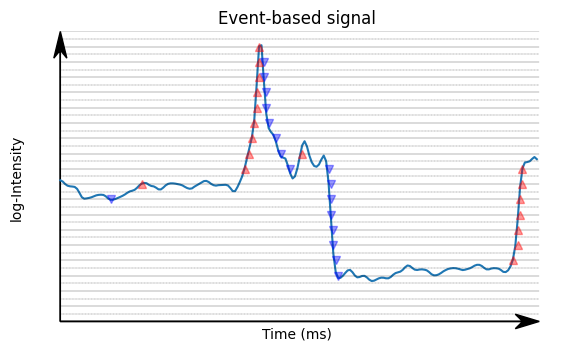

In [17]:
for N_event in [1, 2, 5, 10, 20, -1]:
    fig, ax = do_plot(movie_line_short, N_threshold=20, N_event=N_event, show_events=False, title='Event-based signal')
    plt.show()
    printfig(fig, f'event-based_signal_raw_{N_event}')

[(8, -1.0, 0.6931078095660842), (77, 1.0, 0.7393149968704898), (79, 1.0, 0.7855221841748955), (81, 1.0, 0.8317293714793011), (82, 1.0, 0.8779365587837068), (82, 1.0, 0.9241437460881124), (83, 1.0, 0.9703509333925181), (83, 1.0, 1.0165581206969236), (85, -1.0, 0.970350933392518), (86, -1.0, 0.9241437460881123), (87, -1.0, 0.8779365587837067), (90, -1.0, 0.831729371479301), (92, -1.0, 0.7855221841748954), (96, -1.0, 0.7393149968704897), (101, 1.0, 0.7855221841748954), (112, -1.0, 0.7393149968704897), (113, -1.0, 0.6931078095660841), (113, -1.0, 0.6469006222616784), (114, -1.0, 0.6006934349572728), (114, -1.0, 0.5544862476528671), (115, -1.0, 0.5082790603484615), (190, 1.0, 0.5544862476528671), (191, 1.0, 0.6006934349572728), (192, 1.0, 0.6469006222616784), (192, 1.0, 0.6931078095660841), (193, 1.0, 0.7393149968704897), (201, -1.0, 0.6931078095660841), (202, -1.0, 0.6469006222616784), (203, -1.0, 0.6006934349572728), (203, -1.0, 0.5544862476528671), (217, 1.0, 0.6006934349572728), (218, 1

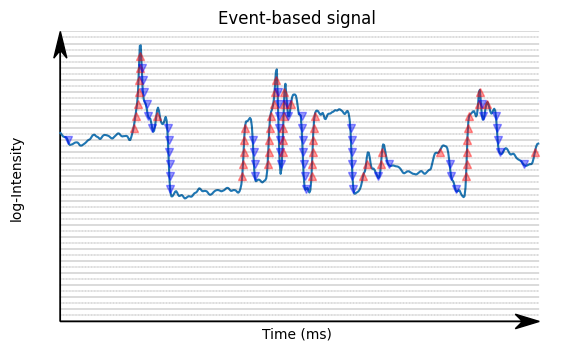

In [18]:
fig, ax = do_plot(movie_line, N_threshold=N_threshold, show_events=False, title='Event-based signal')
printfig(fig, 'event-based_signal_raw')

[(8, -1.0, 0.6931078095660842), (77, 1.0, 0.7393149968704898), (79, 1.0, 0.7855221841748955), (81, 1.0, 0.8317293714793011), (82, 1.0, 0.8779365587837068), (82, 1.0, 0.9241437460881124), (83, 1.0, 0.9703509333925181), (83, 1.0, 1.0165581206969236), (85, -1.0, 0.970350933392518), (86, -1.0, 0.9241437460881123), (87, -1.0, 0.8779365587837067), (90, -1.0, 0.831729371479301), (92, -1.0, 0.7855221841748954), (96, -1.0, 0.7393149968704897), (101, 1.0, 0.7855221841748954), (112, -1.0, 0.7393149968704897), (113, -1.0, 0.6931078095660841), (113, -1.0, 0.6469006222616784), (114, -1.0, 0.6006934349572728), (114, -1.0, 0.5544862476528671), (115, -1.0, 0.5082790603484615), (190, 1.0, 0.5544862476528671), (191, 1.0, 0.6006934349572728), (192, 1.0, 0.6469006222616784), (192, 1.0, 0.6931078095660841), (193, 1.0, 0.7393149968704897), (201, -1.0, 0.6931078095660841), (202, -1.0, 0.6469006222616784), (203, -1.0, 0.6006934349572728), (203, -1.0, 0.5544862476528671), (217, 1.0, 0.6006934349572728), (218, 1

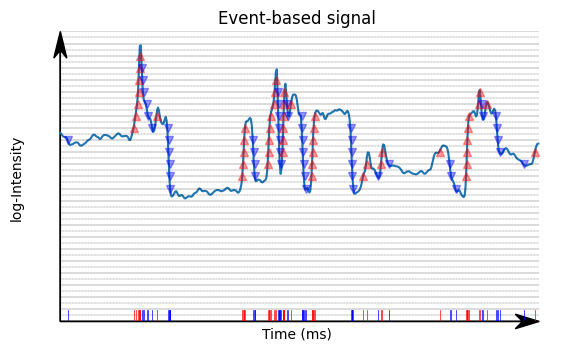

In [19]:
fig, ax = do_plot(movie_line, N_threshold=N_threshold, title='Event-based signal')
printfig(fig, 'event-based_signal')

[(8, -1.0, 0.6931078095660842), (77, 1.0, 0.7393149968704898), (79, 1.0, 0.7855221841748955), (81, 1.0, 0.8317293714793011), (82, 1.0, 0.8779365587837068), (82, 1.0, 0.9241437460881124), (83, 1.0, 0.9703509333925181), (83, 1.0, 1.0165581206969236), (85, -1.0, 0.970350933392518), (86, -1.0, 0.9241437460881123), (87, -1.0, 0.8779365587837067), (90, -1.0, 0.831729371479301), (92, -1.0, 0.7855221841748954), (96, -1.0, 0.7393149968704897), (101, 1.0, 0.7855221841748954), (112, -1.0, 0.7393149968704897), (113, -1.0, 0.6931078095660841), (113, -1.0, 0.6469006222616784), (114, -1.0, 0.6006934349572728), (114, -1.0, 0.5544862476528671), (115, -1.0, 0.5082790603484615), (190, 1.0, 0.5544862476528671), (191, 1.0, 0.6006934349572728), (192, 1.0, 0.6469006222616784), (192, 1.0, 0.6931078095660841), (193, 1.0, 0.7393149968704897), (201, -1.0, 0.6931078095660841), (202, -1.0, 0.6469006222616784), (203, -1.0, 0.6006934349572728), (203, -1.0, 0.5544862476528671), (217, 1.0, 0.6006934349572728), (218, 1

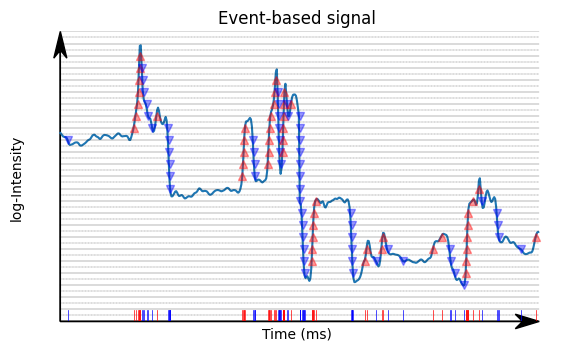

In [20]:
movie_line_low = movie_line.copy()
movie_line_low[len(movie_line)//2:] -= 8 * (movie_line.max() / N_threshold)
fig, ax = do_plot(movie_line_low, N_threshold=N_threshold, title='Event-based signal')
printfig(fig, 'event-based_signal_low')